In [118]:
# Imports
import pymssql
import pandas as pd
import numpy as np
from config import database
from config import username
from config import password
from config import server
from config import asthma_table
from config import aq_table
from config import census_table
from config import county_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump
from sklearn.impute import SimpleImputer



In [119]:
conn = pymssql.connect(server, username, password, database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    INNER JOIN {county_table} ON {asthma_table}.COUNTY_ID = {county_table}.COUNTY_ID
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query, conn)
print(len(df))
df.head(10)



D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


247


,ASTHMA_ID,COUNTY_ID,YEAR,NUM_ED_VISITS,AGE_ADJ_ED_VISITS,AQ_ID,AQ_ID,COUNTY_ID,YEAR,LEAD_MEAN,...,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,SO2_METHOD_ID,SO2_METRIC_ID,SO2_UNITS_ID,COUNTY_ID,COUNTY_NAME,STATE_ID
0,220,862,2018,1770,38.0,767,767,862,2018,NaN,...,NaN,NaN,NaN,NaN,3,2,2,862,Sonoma,15
1,49,809,2015,3281,60.7,768,768,809,2015,NaN,...,NaN,NaN,NaN,NaN,3,2,2,809,Stanislaus,15
2,119,65,2017,198,55.1,769,769,65,2017,NaN,...,NaN,NaN,NaN,NaN,3,2,2,65,Calaveras,15
3,236,46,2019,5910,54.2,770,770,46,2019,NaN,...,NaN,NaN,NaN,NaN,3,2,2,46,Contra Costa,15
4,74,603,2016,487,79.4,771,771,603,2016,NaN,...,NaN,NaN,NaN,NaN,3,2,2,603,Lake,15
5,100,1737,2016,5534,29.1,772,772,1737,2016,NaN,...,1.800000,1.60,0.381402,1.70,3,2,2,1737,Santa Clara,15
6,19,3118,2015,52227,53.1,773,773,3118,2015,0.012374,...,21.666667,8.30,1.838851,9.70,3,2,2,3118,Los Angeles,15
7,94,2343,2016,10068,30.9,774,774,2343,2016,NaN,...,1.200000,0.65,0.154843,0.65,3,2,2,2343,San Diego,15
8,147,586,2017,10076,43.2,775,775,586,2017,0.005121,...,2.500000,1.90,0.414118,2.30,3,2,2,586,Riverside,15
9,87,2491,2016,8878,29.2,776,776,2491,2016,NaN,...,3.300000,2.10,0.496436,3.20,3,2,2,2491,Orange,15


In [120]:
# Exploratory
df.drop(['ASTHMA_ID', "NUM_ED_VISITS", "AQ_ID", "STATE_ID"],
        axis=1, inplace=True, errors="ignore") 
params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   COUNTY_ID          247 non-null    int64  
 1   YEAR               247 non-null    int64  
 2   AGE_ADJ_ED_VISITS  247 non-null    float64
 3   COUNTY_ID          247 non-null    int64  
 4   YEAR               247 non-null    int64  
 5   LEAD_MEAN          17 non-null     float64
 6   LEAD_1STMAX        17 non-null     float64
 7   LEAD_99PERC        17 non-null     float64
 8   LEAD_STD           17 non-null     float64
 9   LEAD_2NDMAX        17 non-null     float64
 10  NO2_MEAN           163 non-null    float64
 11  NO2_1STMAX         163 non-null    float64
 12  NO2_99PERC         163 non-null    float64
 13  NO2_STD            163 non-null    float64
 14  NO2_2NDMAX         163 non-null    float64
 15  OZONE_MEAN         240 non-null    float64
 16  OZONE_1STMAX       240 non

In [121]:
### Clean it
# Drop unnecessary columns

params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

# Remove lead and PM10 columns because they have so few measurements
params = ["LEAD", "PM10"]
for param in params:
    df.drop([f"{param}_MEAN", f"{param}_1STMAX",
            f"{param}_99PERC", f"{param}_STD", f"{param}_2NDMAX"],
            axis=1, inplace=True, errors="ignore")


df[:]

# Use this later when we want to select out different parameters
df_2 = df


In [122]:
## Do a correlation matrix to see how it all looks
corrMatrix = df.loc[:, ~df.columns.isin(
    ['YEAR', 'COUNTY_NAME', 'COUNTY_ID'])].corr()
print(corrMatrix)


                   AGE_ADJ_ED_VISITS  NO2_MEAN  NO2_1STMAX  NO2_99PERC  \
AGE_ADJ_ED_VISITS           1.000000 -0.021139   -0.064298   -0.073378   
NO2_MEAN                   -0.021139  1.000000    0.864178    0.909016   
NO2_1STMAX                 -0.064298  0.864178    1.000000    0.959608   
NO2_99PERC                 -0.073378  0.909016    0.959608    1.000000   
NO2_STD                    -0.049937  0.870100    0.883105    0.941416   
NO2_2NDMAX                 -0.072682  0.890556    0.981767    0.984549   
OZONE_MEAN                  0.110579  0.447888    0.294038    0.332421   
OZONE_1STMAX                0.131153  0.629714    0.467283    0.485924   
OZONE_99PERC                0.144271  0.579403    0.391246    0.435271   
OZONE_STD                   0.265843  0.533410    0.382473    0.418485   
OZONE_2NDMAX                0.128170  0.603987    0.436486    0.459172   
PM25_MEAN                   0.351111  0.225897    0.212884    0.232399   
PM25_1STMAX                 0.139768 -

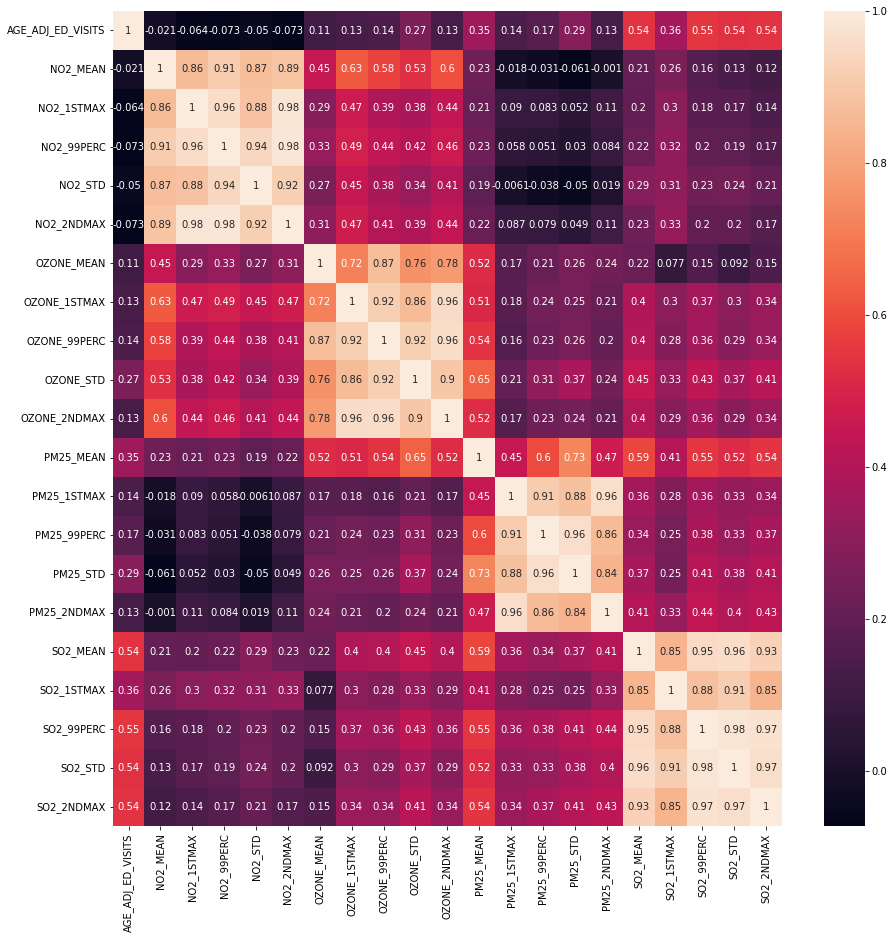

In [123]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sn.heatmap(corrMatrix, annot=True)

plt.show()


This shows some troubling correlations between NO2 and ozone that may indicate multi-colinearity between the two. Additionally, the NO2 correlation to the asthma rate appears very low. Because of that, remove the NO2 variables and continue.

In [124]:
# Remove NO2 and SO2 columns 
params = ["NO2", "SO2"]
for param in params:
    df.drop([f"{param}_MEAN", f"{param}_1STMAX",
            f"{param}_99PERC", f"{param}_STD", f"{param}_2NDMAX"],
            axis=1, inplace=True, errors="ignore")

In [125]:
df.isnull().sum()


COUNTY_ID              0
YEAR                   0
AGE_ADJ_ED_VISITS      0
COUNTY_ID              0
YEAR                   0
OZONE_MEAN             7
OZONE_1STMAX           7
OZONE_99PERC           7
OZONE_STD              7
OZONE_2NDMAX           7
PM25_MEAN            141
PM25_1STMAX          141
PM25_99PERC          141
PM25_STD             141
PM25_2NDMAX          141
COUNTY_ID              0
COUNTY_NAME            0
dtype: int64

There are a lot of empty rows in the PM25 and SO2 columns. The data set is small already so it would be nice to be able to impute values for them and continue. Create two dataframes to compare: one that drops the empty columns and one that we impute values for missing data.

There are also some duplicate columns due to the merge operation during loading. Let's get rid of them so we can reference those columns directly.

In [126]:
# # Remove any rows that still have nulls
df_dropnulls = df.dropna(axis=0, how="any", inplace=False)
df_dropnulls.drop(['YEAR', "COUNTY_NAME"],
        axis=1, inplace=True, errors="ignore") 
print(df_dropnulls.shape)
df_dropnulls

(100, 14)


C:\Users\Darrell\AppData\Local\Temp\ipykernel_20532\3511971506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropnulls.drop(['YEAR', "COUNTY_NAME"],


,COUNTY_ID,AGE_ADJ_ED_VISITS,COUNTY_ID,OZONE_MEAN,OZONE_1STMAX,OZONE_99PERC,OZONE_STD,OZONE_2NDMAX,PM25_MEAN,PM25_1STMAX,PM25_99PERC,PM25_STD,PM25_2NDMAX,COUNTY_ID
3,46,54.2,46,0.041853,0.093000,0.076500,0.011707,0.086250,6.133333,25.500000,25.500000,3.794034,17.200,46
5,1737,29.1,1737,0.044737,0.088250,0.077750,0.011794,0.082750,8.045263,22.700000,22.700000,3.834162,20.300,1737
6,3118,53.1,3118,0.054857,0.112308,0.099923,0.017255,0.105385,10.928321,51.410000,40.335000,6.861900,42.685,3118
7,2343,30.9,2343,0.050642,0.085727,0.080727,0.010884,0.082818,8.451769,23.533333,19.866667,3.427879,18.600,2343
8,586,43.2,586,0.060352,0.114364,0.104545,0.017974,0.111636,12.455025,46.150000,40.600000,7.090441,40.875,586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2778,67.0,2778,0.055849,0.108800,0.098000,0.018154,0.101400,16.477120,84.025000,77.400000,15.593288,72.100,2778
243,1113,60.2,1113,0.043386,0.079250,0.072000,0.011732,0.077250,9.082204,31.150000,22.200000,4.833899,22.225,1113
244,1797,70.7,1797,0.044345,0.072000,0.065667,0.009165,0.068333,4.597626,39.670000,19.820000,4.240796,31.100,1797
245,152,42.2,152,0.052732,0.094750,0.082250,0.012370,0.088750,13.773410,411.700000,192.500000,32.422845,299.900,152


In [127]:
### Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X_dropnulls = df_dropnulls.drop(['AGE_ADJ_ED_VISITS', 'COUNTY_ID'], axis=1)
y_dropnulls = df_dropnulls['AGE_ADJ_ED_VISITS']

X_train_dropnulls, X_test_dropnulls, y_train_dropnulls, y_test_dropnulls = train_test_split(
    X_dropnulls, y_dropnulls, test_size=0.25, random_state=0)

print(X_dropnulls.columns)


Index(['OZONE_MEAN', 'OZONE_1STMAX', 'OZONE_99PERC', 'OZONE_STD',
       'OZONE_2NDMAX', 'PM25_MEAN', 'PM25_1STMAX', 'PM25_99PERC', 'PM25_STD',
       'PM25_2NDMAX'],
      dtype='object')


### Imputing

Ozone
First, let's look at the seven missing values and see what we need to do.

In [128]:
df[df.OZONE_MEAN.isnull()]

,COUNTY_ID,YEAR,AGE_ADJ_ED_VISITS,COUNTY_ID,YEAR,OZONE_MEAN,OZONE_1STMAX,OZONE_99PERC,OZONE_STD,OZONE_2NDMAX,PM25_MEAN,PM25_1STMAX,PM25_99PERC,PM25_STD,PM25_2NDMAX,COUNTY_ID,COUNTY_NAME
46,1349,2019,53.4,1349,2019,NaN,NaN,NaN,NaN,NaN,10.296522,36.366667,34.366667,8.171952,34.633333,1349,Plumas
56,3048,2019,46.5,3048,2019,NaN,NaN,NaN,NaN,NaN,5.322581,26.000000,26.000000,3.937449,20.000000,3048,Mono
102,3048,2018,54.9,3048,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3048,Mono
144,1349,2015,56.3,1349,2015,NaN,NaN,NaN,NaN,NaN,17.193006,50.600000,47.500000,11.262822,44.466667,1349,Plumas
152,1349,2018,61.5,1349,2018,NaN,NaN,NaN,NaN,NaN,12.452474,54.366667,40.766667,9.831300,43.633333,1349,Plumas
162,1349,2016,61.4,1349,2016,NaN,NaN,NaN,NaN,NaN,11.615815,46.800000,42.166667,9.406446,42.166667,1349,Plumas
236,1349,2017,63.2,1349,2017,NaN,NaN,NaN,NaN,NaN,13.778661,73.766667,61.633333,12.336093,68.333333,1349,Plumas


The missing ozone values appear to be from three counts over a series of years. We can more intelligently fill those in by looking at adjacent years and/or adjacent counties.

### KNN Imputer
A KNN imputer uses the K rows most similar to the row missing values in the non-missing values to impute. This may be the most effective approach since we have geographic data. Including the geographic information and year can help the imputer use those in the distance measurement. 

In [129]:
### Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X_KNNImpute = df.drop(['AGE_ADJ_ED_VISITS', 'COUNTY_NAME'], axis=1)
y_KNNImpute = df['AGE_ADJ_ED_VISITS']
print(X_KNNImpute.columns)

X_train_KNNImpute, X_test_KNNImpute, y_train_KNNImpute, y_test_KNNImpute = train_test_split(
    X_KNNImpute, y_KNNImpute, test_size=0.25, random_state=0)

Index(['COUNTY_ID', 'YEAR', 'COUNTY_ID', 'YEAR', 'OZONE_MEAN', 'OZONE_1STMAX',
       'OZONE_99PERC', 'OZONE_STD', 'OZONE_2NDMAX', 'PM25_MEAN', 'PM25_1STMAX',
       'PM25_99PERC', 'PM25_STD', 'PM25_2NDMAX', 'COUNTY_ID'],
      dtype='object')


In [130]:
from sklearn.impute import KNNImputer

imputer_train = KNNImputer(n_neighbors=3)
imputer_test = KNNImputer(n_neighbors=3)
X_train_KNNImpute = pd.DataFrame(imputer_train.fit_transform(X_train_KNNImpute))
X_test_KNNImpute = pd.DataFrame(imputer_test.fit_transform(X_test_KNNImpute))
X_train_KNNImpute.columns = X_KNNImpute.columns
X_test_KNNImpute.columns = X_KNNImpute.columns

X_train_KNNImpute = X_train_KNNImpute.drop(['COUNTY_ID', 'YEAR'], axis=1)
X_test_KNNImpute = X_test_KNNImpute.drop(['COUNTY_ID', 'YEAR'], axis=1)
print(X_train_KNNImpute)




     OZONE_MEAN  OZONE_1STMAX  OZONE_99PERC  OZONE_STD  OZONE_2NDMAX  \
0      0.059722      0.109625      0.095625   0.016895      0.100250   
1      0.037338      0.096000      0.074000   0.010631      0.078000   
2      0.052716      0.098500      0.090500   0.013905      0.093500   
3      0.052562      0.103333      0.094000   0.013388      0.101333   
4      0.040909      0.098400      0.086200   0.012221      0.092000   
..          ...           ...           ...        ...           ...   
180    0.055558      0.102000      0.093000   0.015603      0.096500   
181    0.052365      0.090800      0.084000   0.011613      0.088200   
182    0.048798      0.096000      0.087500   0.015491      0.091500   
183    0.050933      0.087000      0.080000   0.011028      0.084000   
184    0.032106      0.057000      0.047500   0.007361      0.048000   

     PM25_MEAN  PM25_1STMAX  PM25_99PERC   PM25_STD  PM25_2NDMAX  
0    15.708303    78.050000    70.050000  13.727503    69.650000  
1

## AdaBoost

In [131]:
from sklearn import preprocessing



scaler_train_dropnulls = preprocessing.StandardScaler().fit(X_train_dropnulls)
X_train_scaled_dropnulls = scaler_train_dropnulls.transform(X_train_dropnulls)
print('X_train_scaled_dropnulls')
print(X_train_dropnulls.columns)

ScalingDF = pd.DataFrame({'Mean': scaler_train_dropnulls.mean_, 'Var': scaler_train_dropnulls.var_})
ScalingDF.index = X_train_dropnulls.columns
print(ScalingDF)
ScalingDF.to_json('X_train_scaled_O_PM25_dropnulls.json')


scaler_test_dropnulls = preprocessing.StandardScaler().fit(X_test_dropnulls)
X_test_scaled_dropnulls = scaler_test_dropnulls.transform(X_test_dropnulls)

scaler_train_KNNImpute = preprocessing.StandardScaler().fit(X_train_KNNImpute)
X_train_scaled_KNNImpute = scaler_train_KNNImpute.transform(X_train_KNNImpute)

scaler_test_KNNImpute = preprocessing.StandardScaler().fit(X_test_KNNImpute)
X_test_scaled_KNNImpute = scaler_test_KNNImpute.transform(X_test_KNNImpute)


X_train_scaled_dropnulls
Index(['OZONE_MEAN', 'OZONE_1STMAX', 'OZONE_99PERC', 'OZONE_STD',
       'OZONE_2NDMAX', 'PM25_MEAN', 'PM25_1STMAX', 'PM25_99PERC', 'PM25_STD',
       'PM25_2NDMAX'],
      dtype='object')
                   Mean          Var
OZONE_MEAN     0.051270     0.000033
OZONE_1STMAX   0.095943     0.000180
OZONE_99PERC   0.086267     0.000138
OZONE_STD      0.014299     0.000009
OZONE_2NDMAX   0.090571     0.000160
PM25_MEAN     10.697052    19.512307
PM25_1STMAX   56.960213  2638.031381
PM25_99PERC   43.505808   912.745288
PM25_STD       8.324545    27.659864
PM25_2NDMAX   43.397475  1264.629639


In [132]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Adaboost using the dropped nulls dataframe
print("DROPPED NULLS")


ABR_dropnulls = AdaBoostRegressor(random_state=0)
params = {
    'n_estimators': [100, 500, 1000, 1500, 3000, 5000, 10000],
    'learning_rate': [.5, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.8, 2.0]
}
regr_dropnulls = GridSearchCV(
    estimator=ABR_dropnulls,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(regr_dropnulls.best_params_)

# Adaboost using the KNN imputer to fill in missing values
print("KNN IMPUTER")


ABR_KNNImpute = AdaBoostRegressor(random_state=0)

regr_KNNImpute = GridSearchCV(
    estimator=ABR_KNNImpute,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
print(regr_KNNImpute.best_params_)


DROPPED NULLS
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 0.8, 'n_estimators': 100}
KNN IMPUTER
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 1.1, 'n_estimators': 100}


In [133]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from joblib import dump, load

# Retrain the model using just the optimized parameters
print("DROPPED NULLS")
ABR_dropnulls = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_dropnulls.best_params_['n_estimators'], 
                                  learning_rate=regr_dropnulls.best_params_['learning_rate'])
ABR_dropnulls.fit(X_train_dropnulls, y_train_dropnulls)
scores = cross_val_score(ABR_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE = {mean_squared_error(y_train_dropnulls, ABR_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2 = {ABR_dropnulls.score(X_test_dropnulls, y_test_dropnulls)} MSE = {mean_squared_error(y_test_dropnulls, ABR_dropnulls.predict(X_test_scaled_dropnulls))}")

print("KNN IMPUTER")
ABR_KNNImpute = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_KNNImpute.best_params_['n_estimators'], 
                                  learning_rate=regr_KNNImpute.best_params_['learning_rate'])
ABR_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(ABR_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE = {mean_squared_error(y_train_KNNImpute, ABR_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2 = {ABR_KNNImpute.score(X_test_KNNImpute, y_test_KNNImpute)} MSE = {mean_squared_error(y_test_KNNImpute, ABR_KNNImpute.predict(X_test_scaled_KNNImpute))}")

dump(ABR_dropnulls, r"ABR_O_PM25_scaled_dumpnulls.model")
dump(ABR_KNNImpute, r"ABR_O_PM25_scaled_KNNImpute.model")


DROPPED NULLS
Cross-Validation Mean Scores: 0.04167279488458016
TRAIN: R2 = -0.2882662378301364 MSE = 310.6286699155133
TEST: R2 = 0.34679989498058417 MSE = 318.8802729976779
KNN IMPUTER


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


Cross-Validation Mean Scores: 0.02649490260335017
TRAIN: R2 = 0.5409301500720168 MSE = 106.34222012325233
TEST: R2 = -0.28935208310191585 MSE = 210.7654930373919


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(


['ABR_O_PM25_scaled_KNNImpute.model']

The marked difference between the scores on the training set and the testing set indicate that the KNN Imputed model is highly overfit using the optimized parameters. The very low cross validation scores indicate a similar concern. 

Try the drop nulls model on the KNN imputed data to see how it does.

In [134]:
print(f"TRAIN: R2 = {ABR_dropnulls.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE = {mean_squared_error(y_train_KNNImpute, ABR_dropnulls.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2 = {ABR_dropnulls.score(X_test_KNNImpute, y_test_KNNImpute)} MSE = {mean_squared_error(y_test_KNNImpute, ABR_dropnulls.predict(X_test_scaled_KNNImpute))}")


TRAIN: R2 = -0.5820051963177539 MSE = 366.4669872119535
TEST: R2 = 0.15833865963198956 MSE = 254.04432633024697


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


This model didn't perform nearly as well.

D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


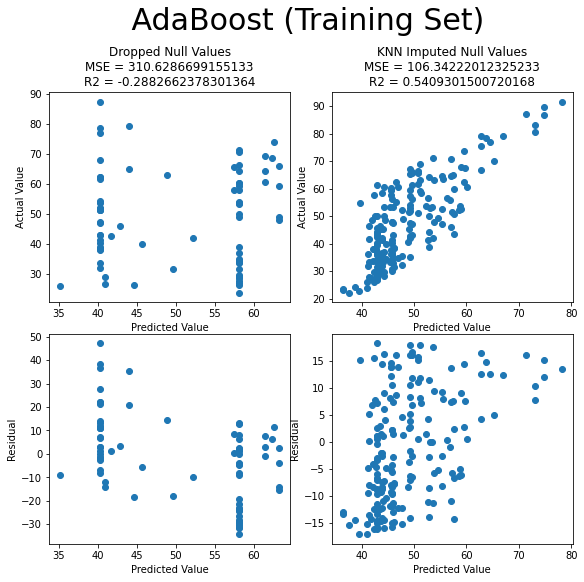

In [135]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Plot the predicted versus actual values and the residual versus predicted values
predict_ABR_dropnulls = ABR_dropnulls.predict(X_train_scaled_dropnulls)
residual_ABR_dropnulls = y_train_dropnulls - predict_ABR_dropnulls
MSE_ABR_dropnulls = mean_squared_error(
    y_train_dropnulls, predict_ABR_dropnulls)

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ABR_KNNImpute = y_train_KNNImpute - predict_ABR_KNNImpute
MSE_ABR_KNNImpute = mean_squared_error(y_train_KNNImpute, predict_ABR_KNNImpute)

cols = [f'Dropped Null Values\nMSE = {MSE_ABR_dropnulls}\nR2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'KNN Imputed Null Values\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' AdaBoost (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_dropnulls, y_train_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_dropnulls, residual_ABR_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_ABR_KNNImpute, y_train_KNNImpute)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")


plt.show()



## Linear Regression

In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Linear Regression using the dropped nulls dataframe
print("Linear Regression - DROPPED NULLS")
linear_dropnulls = LinearRegression()
linear_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(
    linear_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {linear_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE = {mean_squared_error(y_train_dropnulls, linear_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2 = {linear_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE = {mean_squared_error(y_test_dropnulls, linear_dropnulls.predict(X_test_scaled_dropnulls))}")

# Linear Regression using the KNN imputed dataframe
print("Linear Regression - KNN Imputed")
linear_KNNImpute = LinearRegression()
linear_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(
    linear_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {linear_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE = {mean_squared_error(y_train_KNNImpute, linear_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2 = {linear_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)} MSE = {mean_squared_error(y_test_KNNImpute, linear_KNNImpute.predict(X_test_scaled_KNNImpute))}")

# LASSO using the dropped nulls dataframe
print("Lasso Regression - DROPPED NULLS")
Lasso_dropnulls = Lasso(random_state = 0)
Lasso_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(
    Lasso_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {Lasso_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE = {mean_squared_error(y_train_dropnulls, Lasso_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2 = {Lasso_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE = {mean_squared_error(y_test_dropnulls, Lasso_dropnulls.predict(X_test_scaled_dropnulls))}")

# Lasso Regression using the KNN imputed dataframe
print("Lasso Regression - KNN Imputed")
Lasso_KNNImpute = Lasso(random_state=0)
Lasso_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(
    Lasso_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {Lasso_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE = {mean_squared_error(y_train_KNNImpute, Lasso_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2 = {Lasso_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)} MSE = {mean_squared_error(y_test_KNNImpute, Lasso_KNNImpute.predict(X_test_scaled_KNNImpute))}")

dump(linear_dropnulls, r"linear_O_PM25_scaled_dumpnulls.model")
dump(linear_KNNImpute, r"linear_O_PM25_scaled_KNNImpute.model")
dump(Lasso_dropnulls, r"lasso_O_PM25_scaled_dumpnulls.model")
dump(Lasso_KNNImpute, r"lasso_O_PM25_scaled_KNNImpute.model")


Linear Regression - DROPPED NULLS
Cross-Validation Mean Scores: -0.23278347278343925
TRAIN: R2 = 0.4786642515601879 MSE = 125.70525048458207
TEST: R2 = 0.17751190393340888 MSE = 124.55159639517568
Linear Regression - KNN Imputed
Cross-Validation Mean Scores: 0.026597675119691667
TRAIN: R2 = 0.191366129337176 MSE = 187.31772754545656
TEST: R2 = -0.05091440239447054 MSE = 189.67462218690352
Lasso Regression - DROPPED NULLS
Cross-Validation Mean Scores: 0.02989244365149566
TRAIN: R2 = 0.31501928472665186 MSE = 165.1635681002705
TEST: R2 = 0.3890515199349883 MSE = 92.51758034093484
Lasso Regression - KNN Imputed
Cross-Validation Mean Scores: 0.003173217178972343
TRAIN: R2 = 0.09047425917898133 MSE = 210.68904122831432
TEST: R2 = -0.038550845293454206 MSE = 187.44318162744563


['lasso_O_PM25_scaled_KNNImpute.model']

## Random Forest

In [137]:
# Don't do random forest for now. It takes too long to run
''' from sklearn.ensemble import RandomForestRegressor

### Run a Random Forest Regressor algorithm and compare ###
param_grid = {
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 8500, 9000, 9500, 10000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [7, 8, 9, 10, 11, 12, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=0)
rf_grid_dropnull = GridSearchCV(
    estimator=rf, param_grid=param_grid, n_jobs=3, verbose=3, cv=5, error_score='raise')
rf_grid_dropnull.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(rf_grid_dropnull.best_params_) '''


" from sklearn.ensemble import RandomForestRegressor\n\n### Run a Random Forest Regressor algorithm and compare ###\nparam_grid = {\n    'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 8500, 9000, 9500, 10000],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth': [7, 8, 9, 10, 11, 12, None],\n    'min_samples_split': [2, 3],\n    'min_samples_leaf': [1, 2],\n    'bootstrap': [True, False]\n}\nrf = RandomForestRegressor(random_state=0)\nrf_grid_dropnull = GridSearchCV(\n    estimator=rf, param_grid=param_grid, n_jobs=3, verbose=3, cv=5, error_score='raise')\nrf_grid_dropnull.fit(X_train_scaled_dropnulls, y_train_dropnulls)\nprint(rf_grid_dropnull.best_params_) "

In [138]:
''' rf_KNNImpute = GridSearchCV(
    estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=3, cv=5, error_score='raise')

rf_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
print(rf_KNNImpute.best_params_) '''


" rf_KNNImpute = GridSearchCV(\n    estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=3, cv=5, error_score='raise')\n\nrf_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)\nprint(rf_KNNImpute.best_params_) "

In [139]:

''' RF_dropnull = RandomForestRegressor(n_estimators=rf_grid_dropnull.best_params_['n_estimators'],
                                    max_features=rf_grid_dropnull.best_params_[
                                        'max_features'],
                                    max_depth=rf_grid_dropnull.best_params_[
                                        'max_depth'],
                                    min_samples_split=rf_grid_dropnull.best_params_[
                                        'min_samples_split'],
                                    min_samples_leaf=rf_grid_dropnull.best_params_[
                                        'min_samples_leaf'],
                                    bootstrap=rf_grid_dropnull.best_params_['bootstrap'])
RF_dropnull.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(
    RF_dropnull, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print("Tuned Random Forest -- Dropped Nulls")
print(scores.mean())
print(
    f"TRAIN: R2={RF_dropnull.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE={mean_squared_error(y_train_dropnulls, RF_dropnull.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2={RF_dropnull.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE={mean_squared_error(y_test_dropnulls, RF_dropnull.predict(X_test_scaled_dropnulls))}")

RF_KNNImpute = RandomForestRegressor(n_estimators=rf_KNNImpute.best_params_['n_estimators'],
                                     max_features=rf_KNNImpute.best_params_[
                                         'max_features'],
                                     max_depth=rf_KNNImpute.best_params_[
                                         'max_depth'],
                                     min_samples_split=rf_KNNImpute.best_params_[
                                         'min_samples_split'],
                                     min_samples_leaf=rf_KNNImpute.best_params_[
                                         'min_samples_leaf'],
                                     bootstrap=rf_KNNImpute.best_params_['bootstrap'])
RF_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(
    RF_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print("Tuned SVR Results -- KNN Imputed")
print(scores.mean())
print(
    f"TRAIN: R2={RF_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE={mean_squared_error(y_train_KNNImpute, RF_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2={RF_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)} MSE={mean_squared_error(y_test_KNNImpute, RF_KNNImpute.predict(X_test_scaled_KNNImpute))}")

dump(RF_dropnull, r"rf_opt_SO2_scaled_dumpnulls.model")
dump(RF_KNNImpute, r"rf_opt_SO2_scaled_KNNImpute.model") '''


' RF_dropnull = RandomForestRegressor(n_estimators=rf_grid_dropnull.best_params_[\'n_estimators\'],\n                                    max_features=rf_grid_dropnull.best_params_[\n                                        \'max_features\'],\n                                    max_depth=rf_grid_dropnull.best_params_[\n                                        \'max_depth\'],\n                                    min_samples_split=rf_grid_dropnull.best_params_[\n                                        \'min_samples_split\'],\n                                    min_samples_leaf=rf_grid_dropnull.best_params_[\n                                        \'min_samples_leaf\'],\n                                    bootstrap=rf_grid_dropnull.best_params_[\'bootstrap\'])\nRF_dropnull.fit(X_train_scaled_dropnulls, y_train_dropnulls)\nscores = cross_val_score(\n    RF_dropnull, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)\nprint("Tuned Random Forest -- Dropped Nulls")\nprint(scores.mean())\npri

## Support Vector Regression
This method works well to fit non-linear relationships. Tuning can be done on the type of surfaces used to fit as well as other hyper-parameters. It is recommended that SVR data be scaled.

In [140]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


SVR_REG = SVR(cache_size = 1000)
params = {
    'kernel': ["rbf", "linear", "poly", "sigmoid"],
    'C': [.5, .7, 1.0, 1.1, 1.2, 1.3, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5 , 6] }

regr_dropnulls = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(f"Dropped Nulls: tuned parameters = {regr_dropnulls.best_params_}")

regr_KNNImpute = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
print(f"KNN Imputed: tuned parameters = {regr_KNNImpute.best_params_}")

svr_opt_dropnulls = SVR(C=regr_dropnulls.best_params_['C'], 
                        kernel=regr_dropnulls.best_params_['kernel'], 
                        degree=regr_dropnulls.best_params_['degree'],
                        gamma=regr_dropnulls.best_params_['gamma'])
svr_opt_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(svr_opt_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print("Tuned SVR Results -- Dropped Nulls")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE={mean_squared_error(y_train_dropnulls, svr_opt_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2={svr_opt_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE={mean_squared_error(y_test_dropnulls, svr_opt_dropnulls.predict(X_test_scaled_dropnulls))}")

svr_opt_KNNImpute = SVR(C=regr_KNNImpute.best_params_['C'],
                        kernel=regr_KNNImpute.best_params_['kernel'],
                        degree=regr_KNNImpute.best_params_['degree'],
                        gamma=regr_KNNImpute.best_params_['gamma'])
svr_opt_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(
    svr_opt_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print("Tuned SVR Results -- KNN Imputed")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE={mean_squared_error(y_train_KNNImpute, svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2={svr_opt_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)} MSE={mean_squared_error(y_test_KNNImpute, svr_opt_KNNImpute.predict(X_test_scaled_KNNImpute))}")

dump(svr_opt_dropnulls, r"svr_opt_O_PM25_scaled_dumpnulls.model")
dump(svr_opt_KNNImpute, r"svr_opt_O_PM25_scaled_KNNImpute.model")


Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
Dropped Nulls: tuned parameters = {'C': 4.5, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
KNN Imputed: tuned parameters = {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Tuned SVR Results -- Dropped Nulls
0.0711555927597364
TRAIN: R2=0.3908786767290596 MSE=146.8722387567358
TEST: R2=0.36128931959469246 MSE=96.72168540745555
Tuned SVR Results -- KNN Imputed
0.11187268941056835
TRAIN: R2=0.6590865941424987 MSE=78.97161718277371
TEST: R2=-0.06004926771024821 MSE=191.32333127638847


['svr_opt_O_PM25_scaled_KNNImpute.model']

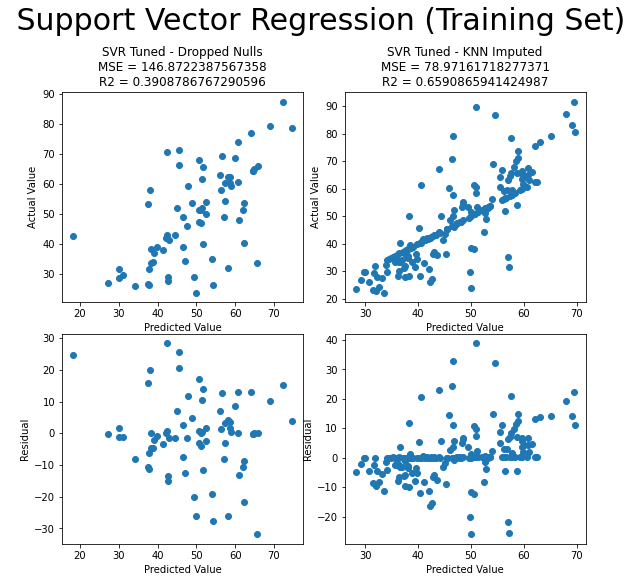

In [141]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_svr_opt_dropnulls = svr_opt_dropnulls.predict(X_train_scaled_dropnulls)
residual_svr_opt_dropnulls = y_train_dropnulls - predict_svr_opt_dropnulls
MSE_svr_opt_dropnulls = mean_squared_error(y_train_dropnulls, predict_svr_opt_dropnulls)

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_train_KNNImpute - predict_svr_opt_KNNImpute
MSE_svr_opt_KNNImpute = mean_squared_error(y_train_KNNImpute, predict_svr_opt_KNNImpute)


cols = [f'SVR Tuned - Dropped Nulls\nMSE = {MSE_svr_opt_dropnulls}\nR2 = {svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'SVR Tuned - KNN Imputed\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}']
#rows = ['','']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' Support Vector Regression (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

#for ax, row in zip(axis[:, 0], rows):
#    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()

axis[0, 0].scatter(predict_svr_opt_dropnulls, y_train_dropnulls)
axis[0,0].set_xlabel("Predicted Value")
axis[0,0].set_ylabel("Actual Value")

axis[1,0].scatter(predict_svr_opt_dropnulls, residual_svr_opt_dropnulls)
axis[1,0].set_ylabel("Residual")
axis[1,0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_KNNImpute, y_train_KNNImpute)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

plt.show()



## Voting Regressor
Take the pretty poor regressors that we developed above and use them together in an ensemble to improve their functionality.

In [142]:
from sklearn.ensemble import VotingRegressor

print("DROPPED NULLS")
ereg_dropnulls = VotingRegressor(
    estimators=[('ABR', ABR_dropnulls), ('svr_opt', svr_opt_dropnulls)])
ereg_dropnulls = ereg_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(ereg_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(scores.mean())

print(f"TEST: R2={ereg_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE={mean_squared_error(y_train_dropnulls, ereg_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2={ereg_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE={mean_squared_error(y_test_dropnulls, ereg_dropnulls.predict(X_test_scaled_dropnulls))}")


print("KNN IMPUTED")
ereg_KNNImpute = VotingRegressor(
    estimators=[('ABR', ABR_KNNImpute), ('svr_opt', svr_opt_KNNImpute)])
ereg_KNNImpute = ereg_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(ereg_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print(scores.mean())

print(f"TEST: R2={ereg_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE={mean_squared_error(y_train_KNNImpute, ereg_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2={ereg_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)} MSE={mean_squared_error(y_test_KNNImpute, ereg_KNNImpute.predict(X_test_scaled_KNNImpute))}")


dump(ereg_dropnulls, r"voting_1_O_PM25_scaled_dumpnulls.model")
dump(ereg_KNNImpute, r"voting_1_O_PM25_scaled_KNNImpute.model")


DROPPED NULLS
0.17619440460376373
TEST: R2=0.6787587407383273 MSE=77.45816986907272
TEST: R2=0.49717823767735503 MSE=76.14365909856346
KNN IMPUTED
0.1179947164516795
TEST: R2=0.6557219271354817 MSE=79.75103268905838
TEST: R2=-0.052551103928807574 MSE=189.97002278703877


['voting_1_O_PM25_scaled_KNNImpute.model']

Try the dropped null model on the larger KNN imputed set to see how it does.

In [143]:
print(
    f"TRAIN: {ereg_dropnulls.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}")
print(f"TEST: {ereg_dropnulls.score(X_test_KNNImpute, y_test_KNNImpute)}")


TRAIN: 0.01728972082322311
TEST: -11.753954306307607


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


It performed poorly.  :(

In [144]:
from sklearn.ensemble import VotingRegressor
# Do a version adding in the linear regression that was pretty good
print("DROPPED NULLS")
ereg2_dropnulls = VotingRegressor(
    estimators=[('ABR', ABR_dropnulls), ('svr_opt', svr_opt_dropnulls), ('lasso', Lasso_dropnulls), ('linear', linear_dropnulls)])
ereg2_dropnulls = ereg2_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(ereg2_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(scores.mean())
print(f"TRAIN: {ereg2_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}")
print(f"TEST: {ereg2_dropnulls.score(X_test_dropnulls, y_test_dropnulls)}")

print("KNN IMPUTED")
ereg2_KNNImpute = VotingRegressor(
    estimators=[('ABR', ABR_KNNImpute), ('svr_opt', svr_opt_KNNImpute), ('lasso', Lasso_KNNImpute), ('linear', linear_KNNImpute)])
ereg2_KNNImpute = ereg2_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(ereg2_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print(scores.mean())
print(f"TRAIN: {ereg2_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}")
print(f"TEST: {ereg2_KNNImpute.score(X_test_KNNImpute, y_test_KNNImpute)}")


dump(ereg2_dropnulls, r"voting_2_O_PM25_scaled_dumpnulls.model")
dump(ereg2_KNNImpute, r"voting_2_O_PM25_scaled_KNNImpute.model")


DROPPED NULLS
0.15561582519506306
TRAIN: 0.5760028627392342
TEST: -362.22694541683154
KNN IMPUTED


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


0.11414592897872682
TRAIN: 0.4583959327012379
TEST: -62.69692495482672


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


['voting_2_O_PM25_scaled_KNNImpute.model']

These don't work well at all on the test set but look nice on the training set.

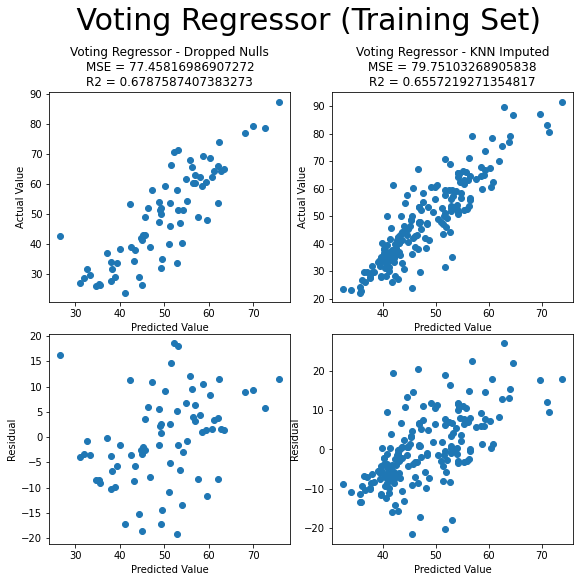

In [145]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_ereg_dropnulls = ereg_dropnulls.predict(X_train_scaled_dropnulls)
residual_ereg_dropnulls = y_train_dropnulls - predict_ereg_dropnulls
MSE_ereg_dropnulls = mean_squared_error(
    y_train_dropnulls, predict_ereg_dropnulls)

predict_ereg_KNNImpute = ereg_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ereg_KNNImpute = y_train_KNNImpute - predict_ereg_KNNImpute
MSE_ereg_KNNImpute = mean_squared_error(y_train_KNNImpute, predict_ereg_KNNImpute)

cols = [f'Voting Regressor - Dropped Nulls\nMSE = {MSE_ereg_dropnulls}\nR2 = {ereg_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'Voting Regressor - KNN Imputed\nMSE = {MSE_ereg_KNNImpute}\nR2 = {ereg_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}']
#rows = ['','']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' Voting Regressor (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

#for ax, row in zip(axis[:, 0], rows):
#    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()

axis[0, 0].scatter(predict_ereg_dropnulls, y_train_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ereg_dropnulls, residual_ereg_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_ereg_KNNImpute, y_train_KNNImpute)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_ereg_KNNImpute, residual_ereg_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")
plt.show()


## Plot all of them together for training and test sets

D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


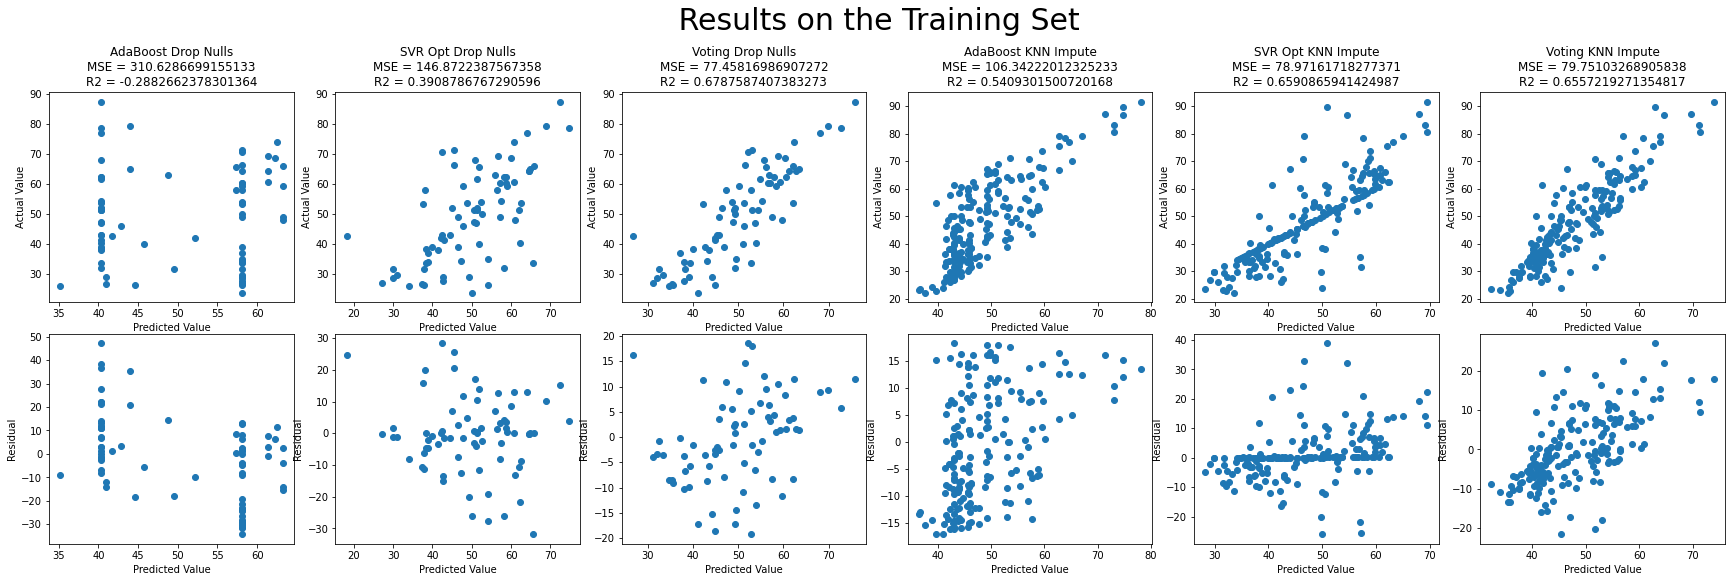

In [146]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR_dropnulls = ABR_dropnulls.predict(X_train_scaled_dropnulls)
residual_ABR_dropnulls = y_train_dropnulls - predict_ABR_dropnulls

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ABR_KNNImpute = y_train_KNNImpute - predict_ABR_KNNImpute

predict_svr_opt_dropnulls = svr_opt_dropnulls.predict(X_train_scaled_dropnulls)
residual_svr_opt_dropnulls = y_train_dropnulls - predict_svr_opt_dropnulls

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_train_KNNImpute - predict_svr_opt_KNNImpute

predict_ereg_dropnulls = ereg_dropnulls.predict(X_train_scaled_dropnulls)
residual_ereg_dropnulls = y_train_dropnulls - predict_ereg_dropnulls

predict_ereg_KNNImpute = ereg_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ereg_KNNImpute = y_train_KNNImpute - predict_ereg_KNNImpute

cols = [f'AdaBoost Drop Nulls\nMSE = {MSE_ABR_dropnulls}\nR2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'SVR Opt Drop Nulls\nMSE = {MSE_svr_opt_dropnulls}\nR2 = {svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'Voting Drop Nulls\nMSE = {MSE_ereg_dropnulls}\nR2 = {ereg_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'AdaBoost KNN Impute\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}',
        f'SVR Opt KNN Impute\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}',
        f'Voting KNN Impute\nMSE = {MSE_ereg_KNNImpute}\nR2 = {ereg_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}']


figure, axis = plt.subplots(2, 6, figsize=(24, 8))
figure.suptitle(' Results on the Training Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_dropnulls, y_train_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_dropnulls, residual_ABR_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_dropnulls, y_train_dropnulls)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_dropnulls, residual_svr_opt_dropnulls)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_ereg_dropnulls, y_train_dropnulls)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_ereg_dropnulls, residual_ereg_dropnulls)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_ABR_KNNImpute, y_train_KNNImpute)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_svr_opt_KNNImpute, y_train_KNNImpute)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")

axis[0, 5].scatter(predict_ereg_KNNImpute, y_train_KNNImpute)
axis[0, 5].set_xlabel("Predicted Value")
axis[0, 5].set_ylabel("Actual Value")

axis[1, 5].scatter(predict_ereg_KNNImpute, residual_ereg_KNNImpute)
axis[1, 5].set_ylabel("Residual")
axis[1, 5].set_xlabel("Predicted Value")


plt.show()


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


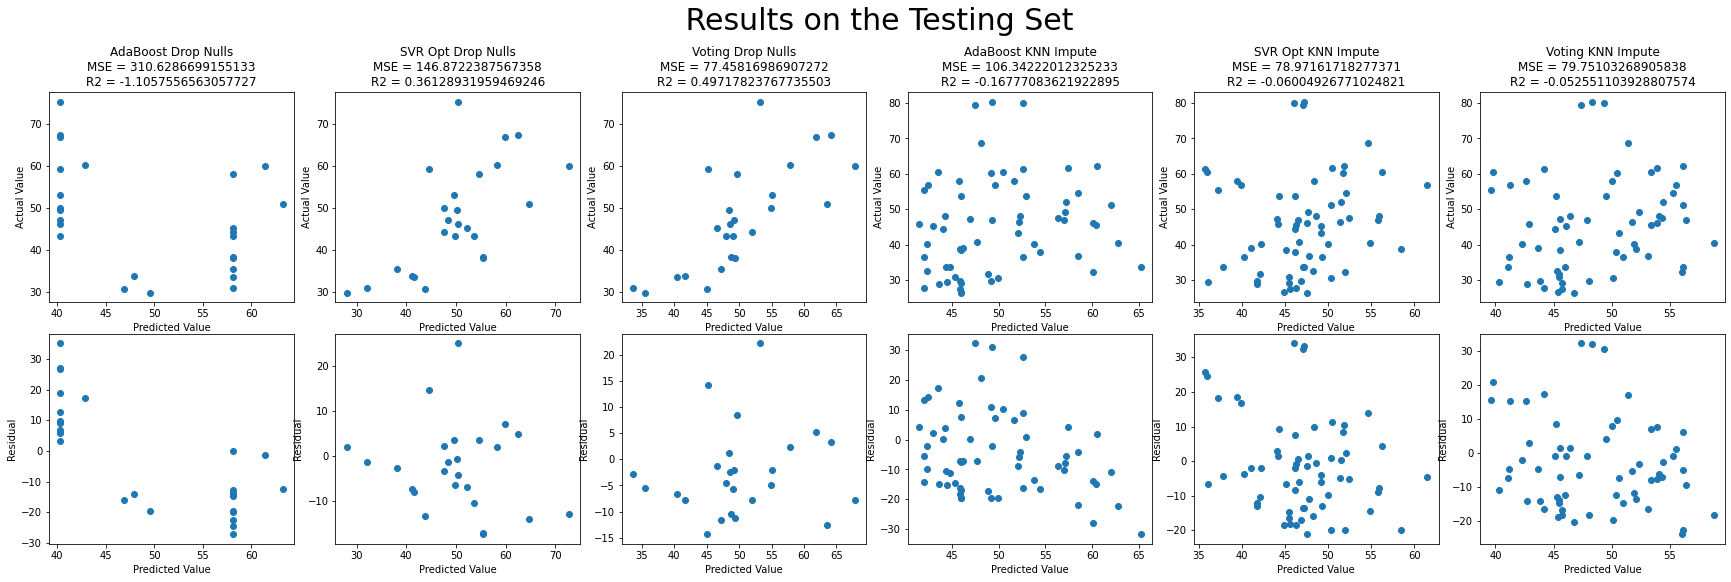

In [147]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR_dropnulls = ABR_dropnulls.predict(X_test_scaled_dropnulls)
residual_ABR_dropnulls = y_test_dropnulls - predict_ABR_dropnulls

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_ABR_KNNImpute = y_test_KNNImpute - predict_ABR_KNNImpute

predict_svr_opt_dropnulls = svr_opt_dropnulls.predict(X_test_scaled_dropnulls)
residual_svr_opt_dropnulls = y_test_dropnulls - predict_svr_opt_dropnulls

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_test_KNNImpute - predict_svr_opt_KNNImpute

predict_ereg_dropnulls = ereg_dropnulls.predict(X_test_scaled_dropnulls)
residual_ereg_dropnulls = y_test_dropnulls - predict_ereg_dropnulls

predict_ereg_KNNImpute = ereg_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_ereg_KNNImpute = y_test_KNNImpute - predict_ereg_KNNImpute

cols = [f'AdaBoost Drop Nulls\nMSE = {MSE_ABR_dropnulls}\nR2 = {ABR_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)}',
        f'SVR Opt Drop Nulls\nMSE = {MSE_svr_opt_dropnulls}\nR2 = {svr_opt_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)}',
        f'Voting Drop Nulls\nMSE = {MSE_ereg_dropnulls}\nR2 = {ereg_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)}',
        f'AdaBoost KNN Impute\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)}',
        f'SVR Opt KNN Impute\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)}',
        f'Voting KNN Impute\nMSE = {MSE_ereg_KNNImpute}\nR2 = {ereg_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)}']


figure, axis = plt.subplots(2, 6, figsize=(24, 8))
figure.suptitle(' Results on the Testing Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_dropnulls, y_test_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_dropnulls, residual_ABR_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_dropnulls, y_test_dropnulls)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_dropnulls, residual_svr_opt_dropnulls)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_ereg_dropnulls, y_test_dropnulls)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_ereg_dropnulls, residual_ereg_dropnulls)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_ABR_KNNImpute, y_test_KNNImpute)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_svr_opt_KNNImpute, y_test_KNNImpute)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")

axis[0, 5].scatter(predict_ereg_KNNImpute, y_test_KNNImpute)
axis[0, 5].set_xlabel("Predicted Value")
axis[0, 5].set_ylabel("Actual Value")

axis[1, 5].scatter(predict_ereg_KNNImpute, residual_ereg_KNNImpute)
axis[1, 5].set_ylabel("Residual")
axis[1, 5].set_xlabel("Predicted Value")


plt.show()


## Use only mean measurements and drop rows with >3 nulls. Impute the rest.
Similar to the approach Abbey used to get the best result with linear regression

In [148]:

df_Model3 = df_2[['OZONE_MEAN',
                'PM25_MEAN']]
df_Model3.dropna(axis=0, how='any', thresh=4, inplace=True)
df_Model3


C:\Users\Darrell\AppData\Local\Temp\ipykernel_20532\3813344701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Model3.dropna(axis=0, how='any', thresh=4, inplace=True)


,OZONE_MEAN,PM25_MEAN


In [149]:
X = df_Model3[['OZONE_MEAN','PM25_MEAN']]
y = df_Model3['AGE_ADJ_ED_VISITS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

KeyError: 'AGE_ADJ_ED_VISITS'

In [ ]:
from sklearn.impute import KNNImputer
mean_imp = SimpleImputer(strategy='mean')
X_train_mean = mean_imp.fit_transform(X_train)
X_test_mean = mean_imp.fit_transform(X_test)

KNN_imp= KNNImputer(n_neighbors=3)
X_train_KNNImpute = KNN_imp.fit_transform(X_train)
X_test_KNNImpute = KNN_imp.fit_transform(X_test)


### Scale the data to use across all of the models

In [ ]:
from sklearn import preprocessing

scaler_train_mean = preprocessing.StandardScaler().fit(X_train_mean)
X_train_scaled_mean = scaler_train_mean.transform(X_train_mean)

scaler_test_mean = preprocessing.StandardScaler().fit(X_test_mean)
X_test_scaled_mean = scaler_test_mean.transform(X_test_mean)

scaler_train_KNNImpute = preprocessing.StandardScaler().fit(X_train_KNNImpute)
X_train_scaled_KNNImpute = scaler_train_KNNImpute.transform(X_train_KNNImpute)

scaler_test_KNNImpute = preprocessing.StandardScaler().fit(X_test_KNNImpute)
X_test_scaled_KNNImpute = scaler_test_KNNImpute.transform(X_test_KNNImpute)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Adaboost using the dropped nulls dataframe
print("Mean Imputer")


ABR_mean = AdaBoostRegressor(random_state=0)
params = {
    'n_estimators': [100, 500, 1000, 1500, 3000, 5000, 10000],
    'learning_rate': [.5, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.8, 2.0]
}
regr_mean = GridSearchCV(
    estimator=ABR_mean,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_mean.fit(X_train_scaled_mean, y_train)
print(regr_mean.best_params_)

# Adaboost using the KNN imputer to fill in missing values
print("KNN IMPUTER")


ABR_KNNImpute2 = AdaBoostRegressor(random_state=0)

regr_KNNImpute2 = GridSearchCV(
    estimator=ABR_KNNImpute2,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_KNNImpute2.fit(X_train_scaled_KNNImpute, y_train)
print(regr_KNNImpute2.best_params_)


Mean Imputer
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 0.7, 'n_estimators': 100}
KNN IMPUTER
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 1.0, 'n_estimators': 500}


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from joblib import dump, load

# Retrain the model using just the optimized parameters
print("Mean Imputer")
ABR_mean = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_mean.best_params_['n_estimators'], 
                                  learning_rate=regr_mean.best_params_['learning_rate'])
ABR_mean.fit(X_train_mean, y_train)
scores = cross_val_score(ABR_mean, X_train_scaled_mean, y_train, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_mean.score(X_train_scaled_mean, y_train)} MSE = {mean_squared_error(y_train, ABR_mean.predict(X_train_scaled_mean))}")
print(f"TEST: R2 = {ABR_mean.score(X_test_mean, y_test)} MSE = {mean_squared_error(y_test, ABR_mean.predict(X_test_scaled_mean))}")

print("KNN IMPUTER")
ABR_KNNImpute = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_KNNImpute2.best_params_['n_estimators'], 
                                  learning_rate=regr_KNNImpute2.best_params_['learning_rate'])
ABR_KNNImpute.fit(X_train_scaled_KNNImpute, y_train)
scores = cross_val_score(ABR_KNNImpute, X_train_scaled_KNNImpute, y_train, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train)} MSE = {mean_squared_error(y_train, ABR_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2 = {ABR_KNNImpute.score(X_test_KNNImpute, y_test)} MSE = {mean_squared_error(y_test, ABR_KNNImpute.predict(X_test_scaled_KNNImpute))}")

dump(ABR_mean, r"ABR_MEANS_scaled_mean.model")
dump(ABR_KNNImpute, r"ABR_MEANS_scaled_KNNImpute.model")


Mean Imputer
Cross-Validation Mean Scores: 0.1753250351716567
TRAIN: R2 = -1.2872828765559245 MSE = 428.079686416165
TEST: R2 = 0.28872167334516996 MSE = 327.24257056334096
KNN IMPUTER
Cross-Validation Mean Scores: 0.08000422273836982
TRAIN: R2 = 0.809109989271409 MSE = 35.72629199922909
TEST: R2 = -0.03131066465649579 MSE = 383.30634406202523


['ABR_MEANS_scaled_KNNImpute.model']

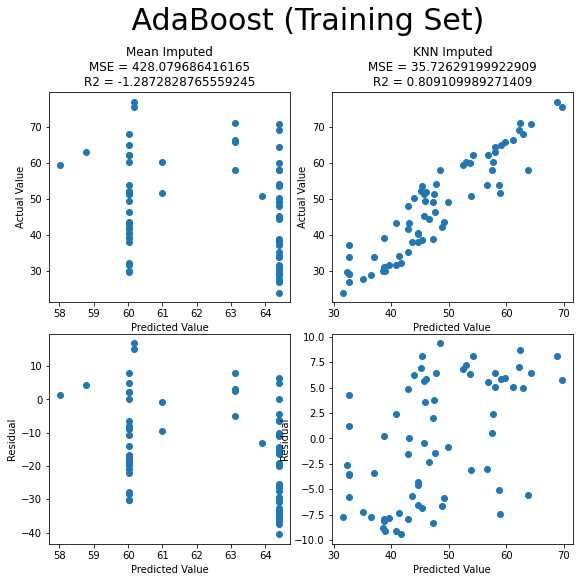

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Plot the predicted versus actual values and the residual versus predicted values
predict_ABR_mean = ABR_mean.predict(X_train_scaled_mean)
residual_ABR_mean = y_train - predict_ABR_mean
MSE_ABR_mean = mean_squared_error(
    y_train, predict_ABR_mean)

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ABR_KNNImpute = y_train - predict_ABR_KNNImpute
MSE_ABR_KNNImpute = mean_squared_error(
    y_train, predict_ABR_KNNImpute)

cols = [f'Mean Imputed\nMSE = {MSE_ABR_mean}\nR2 = {ABR_mean.score(X_train_scaled_mean, y_train)}',
        f'KNN Imputed\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train)}']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' AdaBoost (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_mean, y_train)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_mean, residual_ABR_mean)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_ABR_KNNImpute, y_train)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")


plt.show()


## Support Vector Regression
This method works well to fit non-linear relationships. Tuning can be done on the type of surfaces used to fit as well as other hyper-parameters. It is recommended that SVR data be scaled.

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


SVR_REG = SVR(cache_size = 1000)
params = {
    'kernel': ["rbf", "linear", "poly", "sigmoid"],
    'C': [.5, .7, 1.0, 1.1, 1.2, 1.3, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5 , 6] }

regr_mean = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_mean.fit(X_train_scaled_mean, y_train)
print(f"Mean Imputer: tuned parameters = {regr_mean.best_params_}")

regr_KNNImpute = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_KNNImpute.fit(X_train_scaled_KNNImpute, y_train)
print(f"KNN Imputed: tuned parameters = {regr_KNNImpute.best_params_}")

svr_opt_mean = SVR(C=regr_mean.best_params_['C'],
                        kernel=regr_mean.best_params_['kernel'], 
                   degree=regr_mean.best_params_['degree'],
                   gamma=regr_mean.best_params_['gamma'])
svr_opt_mean.fit(X_train_scaled_mean, y_train)
scores = cross_val_score(svr_opt_mean, X_train_scaled_mean, y_train, cv=5)
print("Tuned SVR Results -- Mean Imputer")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_mean.score(X_train_scaled_mean, y_train)} MSE={mean_squared_error(y_train, svr_opt_mean.predict(X_train_scaled_mean))}")
print(f"TEST: R2={svr_opt_mean.score(X_test_scaled_mean, y_test)} MSE={mean_squared_error(y_test, svr_opt_mean.predict(X_test_scaled_mean))}")

svr_opt_KNNImpute = SVR(C=regr_KNNImpute.best_params_['C'],
                        kernel=regr_KNNImpute.best_params_['kernel'],
                        degree=regr_KNNImpute.best_params_['degree'],
                        gamma=regr_KNNImpute.best_params_['gamma'])
svr_opt_KNNImpute.fit(X_train_scaled_KNNImpute, y_train)
scores = cross_val_score(
    svr_opt_KNNImpute, X_train_scaled_KNNImpute, y_train, cv=5)
print("Tuned SVR Results -- KNN Imputed")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train)} MSE={mean_squared_error(y_train, svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2={svr_opt_KNNImpute.score(X_test_scaled_KNNImpute, y_test)} MSE={mean_squared_error(y_test, svr_opt_KNNImpute.predict(X_test_scaled_KNNImpute))}")

dump(svr_opt_dropnulls, r"svr_opt_MEANS_scaled_mean.model")
dump(svr_opt_KNNImpute, r"svr_opt_MEANS_scaled_KNNImpute.model")


Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
Mean Imputer: tuned parameters = {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
KNN Imputed: tuned parameters = {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Tuned SVR Results -- Mean Imputer
0.34485371727048675
TRAIN: R2=0.8028929263041438 MSE=36.8898552789332
TEST: R2=-0.5544183505276634 MSE=411.88965698646103
Tuned SVR Results -- KNN Imputed
0.36163311622373995
TRAIN: R2=0.7731332334257981 MSE=42.4595730107365
TEST: R2=-0.6607920445525648 MSE=440.0765503857999


['svr_opt_MEANS_scaled_KNNImpute.model']

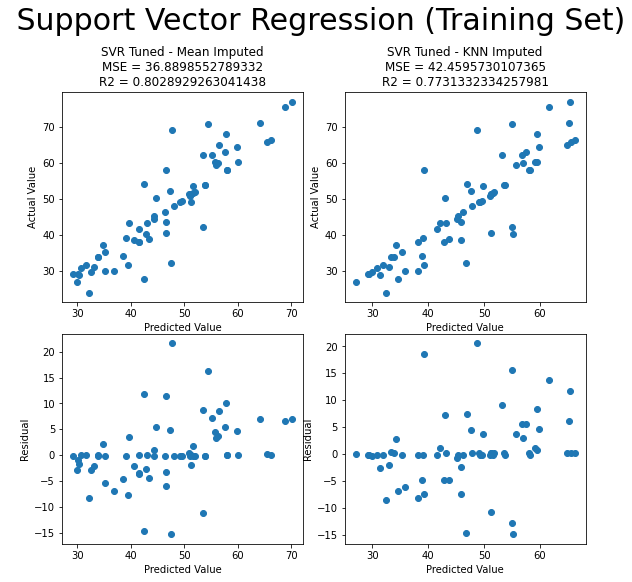

In [ ]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_svr_opt_mean = svr_opt_mean.predict(X_train_scaled_mean)
residual_svr_opt_mean = y_train - predict_svr_opt_mean
MSE_svr_opt_mean = mean_squared_error(y_train, predict_svr_opt_mean)

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_train - predict_svr_opt_KNNImpute
MSE_svr_opt_KNNImpute = mean_squared_error(y_train, predict_svr_opt_KNNImpute)


cols = [f'SVR Tuned - Mean Imputed\nMSE = {MSE_svr_opt_mean}\nR2 = {svr_opt_mean.score(X_train_scaled_mean, y_train)}',
        f'SVR Tuned - KNN Imputed\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train)}']
#rows = ['','']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' Support Vector Regression (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

#for ax, row in zip(axis[:, 0], rows):
#    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()

axis[0, 0].scatter(predict_svr_opt_mean, y_train)
axis[0,0].set_xlabel("Predicted Value")
axis[0,0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_svr_opt_mean, residual_svr_opt_mean)
axis[1,0].set_ylabel("Residual")
axis[1,0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_KNNImpute, y_train)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

plt.show()



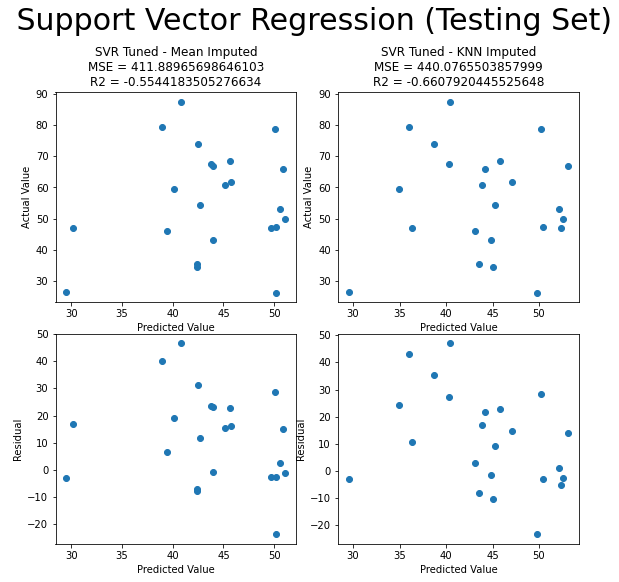

In [ ]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_svr_opt_mean = svr_opt_mean.predict(X_test_scaled_mean)
residual_svr_opt_mean = y_test - predict_svr_opt_mean
MSE_svr_opt_mean = mean_squared_error(y_test, predict_svr_opt_mean)

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_test - predict_svr_opt_KNNImpute
MSE_svr_opt_KNNImpute = mean_squared_error(y_test, predict_svr_opt_KNNImpute)


cols = [f'SVR Tuned - Mean Imputed\nMSE = {MSE_svr_opt_mean}\nR2 = {svr_opt_mean.score(X_test_scaled_mean, y_test)}',
        f'SVR Tuned - KNN Imputed\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_test_scaled_KNNImpute, y_test)}']
#rows = ['','']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' Support Vector Regression (Testing Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

#for ax, row in zip(axis[:, 0], rows):
#    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()

axis[0, 0].scatter(predict_svr_opt_mean, y_test)
axis[0,0].set_xlabel("Predicted Value")
axis[0,0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_svr_opt_mean, residual_svr_opt_mean)
axis[1,0].set_ylabel("Residual")
axis[1,0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_KNNImpute, y_test)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

plt.show()



In [ ]:
from sklearn.ensemble import VotingRegressor

print("Mean Imputed")
ereg_mean = VotingRegressor(
    estimators=[('ABR', ABR_mean), ('svr_opt', svr_opt_mean)])
ereg_mean = ereg_mean.fit(X_train_scaled_mean, y_train)
scores = cross_val_score(ereg_mean, X_train_scaled_mean, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {ereg_mean.score(X_train_scaled_mean, y_train)}")
print(f"TEST: {ereg_mean.score(X_test_mean, y_test)}")

print("KNN IMPUTED")
ereg_KNNImpute = VotingRegressor(
    estimators=[('ABR', ABR_KNNImpute), ('svr_opt', svr_opt_KNNImpute)])
ereg_KNNImpute = ereg_KNNImpute.fit(X_train_scaled_KNNImpute, y_train)
scores = cross_val_score(ereg_KNNImpute, X_train_scaled_KNNImpute, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {ereg_KNNImpute.score(X_train_scaled_KNNImpute, y_train)}")
print(f"TEST: {ereg_KNNImpute.score(X_test_KNNImpute, y_test)}")


dump(ereg_dropnulls, r"voting_1_MEANS_scaled_mean.model")
dump(ereg_KNNImpute, r"voting_1_MEANS_scaled_KNNImpute.model")


Mean Imputed
0.3040479843374063
TRAIN: 0.8178703940487349
TEST: 0.0045588185050534635
KNN IMPUTED
0.27836411722910287
TRAIN: 0.8204811731412911
TEST: 0.01547956036260123


['voting_1_MEANS_scaled_KNNImpute.model']

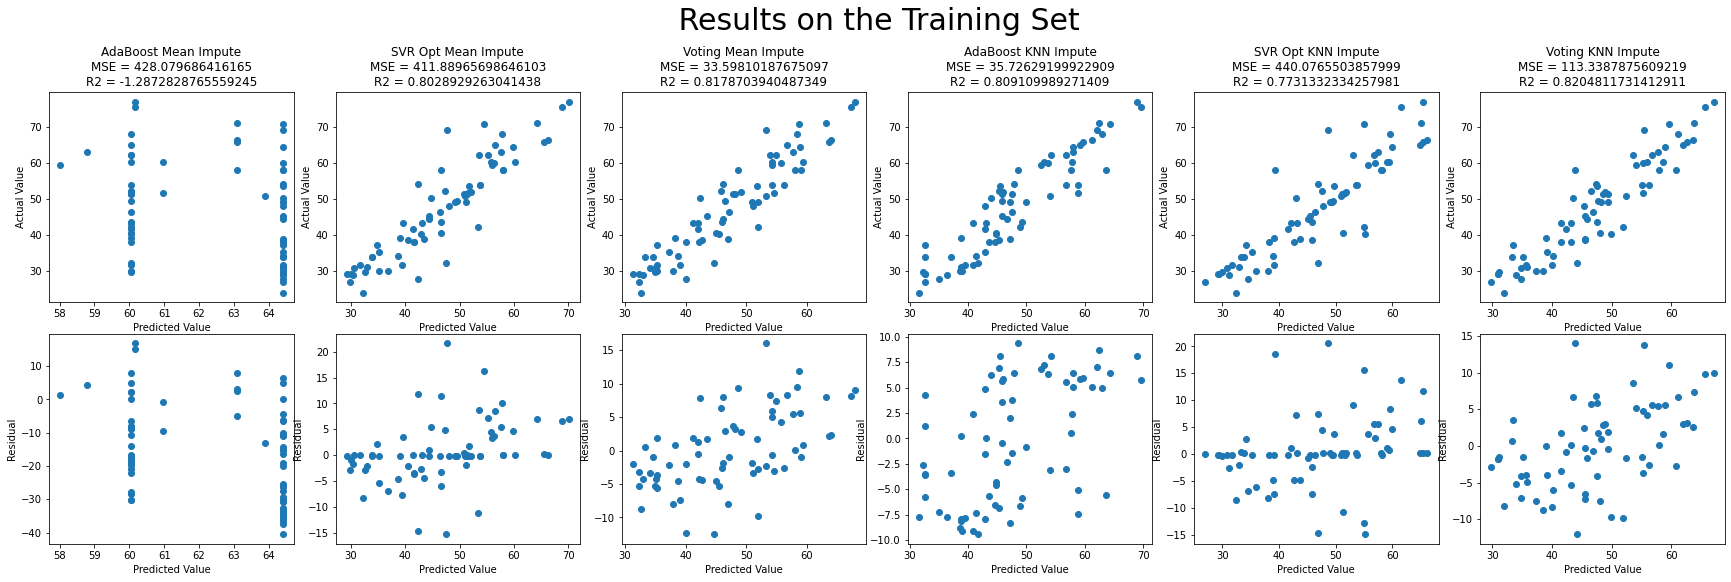

In [ ]:
# checking all of them together against the training set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR_mean = ABR_mean.predict(X_train_scaled_mean)
residual_ABR_mean = y_train - predict_ABR_mean

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ABR_KNNImpute = y_train - predict_ABR_KNNImpute

predict_svr_opt_mean = svr_opt_mean.predict(X_train_scaled_mean)
residual_svr_opt_mean = y_train - predict_svr_opt_mean

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_train - predict_svr_opt_KNNImpute

predict_ereg_mean = ereg_mean.predict(X_train_scaled_mean)
residual_ereg_mean = y_train - predict_ereg_mean
MSE_ereg_mean = mean_squared_error(y_train, predict_ereg_mean)

predict_ereg_KNNImpute = ereg_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ereg_KNNImpute = y_train - predict_ereg_KNNImpute
MSE_ereg_mean = mean_squared_error(y_train, predict_ereg_KNNImpute)

cols = [f'AdaBoost Mean Impute\nMSE = {MSE_ABR_mean}\nR2 = {ABR_mean.score(X_train_scaled_mean, y_train)}',
        f'SVR Opt Mean Impute\nMSE = {MSE_svr_opt_mean}\nR2 = {svr_opt_mean.score(X_train_scaled_mean, y_train)}',
        f'Voting Mean Impute\nMSE = {MSE_ereg_mean}\nR2 = {ereg_mean.score(X_train_scaled_mean, y_train)}',
        f'AdaBoost KNN Impute\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train)}',
        f'SVR Opt KNN Impute\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train)}',
        f'Voting KNN Impute\nMSE = {MSE_ereg_KNNImpute}\nR2 = {ereg_KNNImpute.score(X_train_scaled_KNNImpute, y_train)}']


figure, axis = plt.subplots(2, 6, figsize=(24, 8))
figure.suptitle(' Results on the Training Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_mean, y_train)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_mean, residual_ABR_mean)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_mean, y_train)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_mean, residual_svr_opt_mean)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_ereg_mean, y_train)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_ereg_mean, residual_ereg_mean)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_ABR_KNNImpute, y_train)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_svr_opt_KNNImpute, y_train)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")

axis[0, 5].scatter(predict_ereg_KNNImpute, y_train)
axis[0, 5].set_xlabel("Predicted Value")
axis[0, 5].set_ylabel("Actual Value")

axis[1, 5].scatter(predict_ereg_KNNImpute, residual_ereg_KNNImpute)
axis[1, 5].set_ylabel("Residual")
axis[1, 5].set_xlabel("Predicted Value")


plt.show()


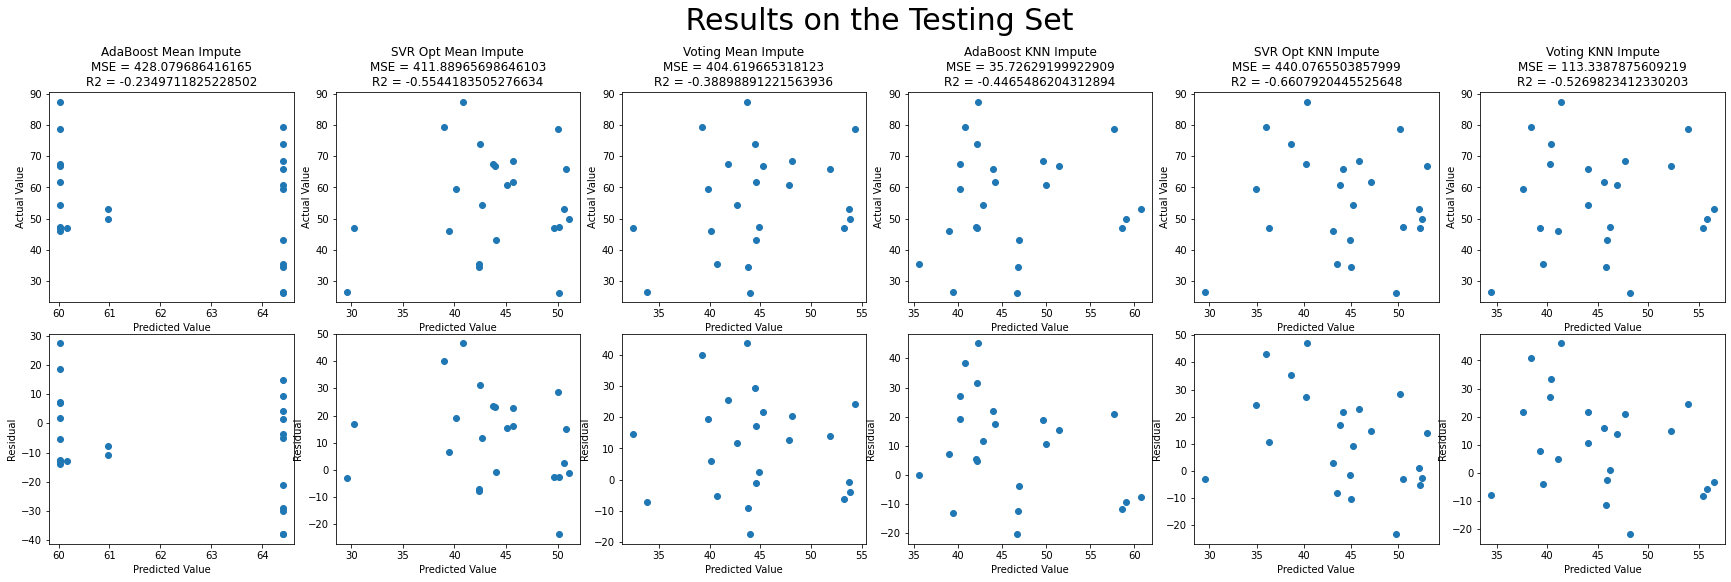

In [ ]:
# checking all of them together against the training set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR_mean = ABR_mean.predict(X_test_scaled_mean)
residual_ABR_mean = y_test - predict_ABR_mean

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_ABR_KNNImpute = y_test - predict_ABR_KNNImpute

predict_svr_opt_mean = svr_opt_mean.predict(X_test_scaled_mean)
residual_svr_opt_mean = y_test - predict_svr_opt_mean

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_test - predict_svr_opt_KNNImpute

predict_ereg_mean = ereg_mean.predict(X_test_scaled_mean)
residual_ereg_mean = y_test - predict_ereg_mean
MSE_ereg_mean = mean_squared_error(y_test, predict_ereg_mean)

predict_ereg_KNNImpute = ereg_KNNImpute.predict(X_test_scaled_KNNImpute)
residual_ereg_KNNImpute = y_test - predict_ereg_KNNImpute
MSE_ereg_mean = mean_squared_error(y_test, predict_ereg_KNNImpute)

cols = [f'AdaBoost Mean Impute\nMSE = {MSE_ABR_mean}\nR2 = {ABR_mean.score(X_test_scaled_mean, y_test)}',
        f'SVR Opt Mean Impute\nMSE = {MSE_svr_opt_mean}\nR2 = {svr_opt_mean.score(X_test_scaled_mean, y_test)}',
        f'Voting Mean Impute\nMSE = {MSE_ereg_mean}\nR2 = {ereg_mean.score(X_test_scaled_mean, y_test)}',
        f'AdaBoost KNN Impute\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_test_scaled_KNNImpute, y_test)}',
        f'SVR Opt KNN Impute\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_test_scaled_KNNImpute, y_test)}',
        f'Voting KNN Impute\nMSE = {MSE_ereg_KNNImpute}\nR2 = {ereg_KNNImpute.score(X_test_scaled_KNNImpute, y_test)}']


figure, axis = plt.subplots(2, 6, figsize=(24, 8))
figure.suptitle(' Results on the Testing Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_mean, y_test)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_mean, residual_ABR_mean)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_mean, y_test)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_mean, residual_svr_opt_mean)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_ereg_mean, y_test)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_ereg_mean, residual_ereg_mean)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_ABR_KNNImpute, y_test)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_svr_opt_KNNImpute, y_test)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")

axis[0, 5].scatter(predict_ereg_KNNImpute, y_test)
axis[0, 5].set_xlabel("Predicted Value")
axis[0, 5].set_ylabel("Actual Value")

axis[1, 5].scatter(predict_ereg_KNNImpute, residual_ereg_KNNImpute)
axis[1, 5].set_ylabel("Residual")
axis[1, 5].set_xlabel("Predicted Value")


plt.show()
